# Forward prediction of Hindi sentiment on `CrowdTangle` dataset

## Installs and imports

In [1]:
!pip install --upgrade pip
!pip install sentencepiece
!pip install datasets
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.1 MB 5.0 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 17.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 441.9/441.9 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.5/163.5 kB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.0/128.0 kB 14.3 MB/s eta 0:00:00
  Attempting uninst

In [2]:
from transformers import AutoTokenizer, AutoConfig, AutoModelForSequenceClassification

from matplotlib import pyplot as plt
from matplotlib.font_manager import FontProperties

from scipy.special import softmax
from torch.utils.data import DataLoader

import numpy as np
import pandas as pd

## Load the `CrowdTangle` dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df = pd.read_csv (
    '/content/drive/My Drive/CrowdTangle-NLP/2022-07-11-16-34-58-CEST-Historical-Report-2016-12-31--2022-07-11.csv',
    low_memory=False,  
    lineterminator='\n', 
    sep=';', 
    error_bad_lines=False)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
df.shape

(604703, 40)

Drop empty strings

In [6]:
df = df.dropna(subset=['message']).reset_index(drop=True)
#df = df.reset_index()
print (len(df))

375922


(**Optional**) Because the size of the dataset is too large, let's choose `N` random entries from the dataframe

In [ ]:
#df = df.sample(n = 50000) # randomly select N entries

In [7]:
df.columns

Index(['account.name', 'account.handle', 'platformId', 'Page Category',
       'Page Admin Top Country', 'Page Description', 'Page Created',
       'subscriberCount', 'Followers at Posting', 'date', 'Post Created Date',
       'Post Created Time', 'type', 'totalInteraction',
       'statistics.actual.likeCount', 'statistics.actual.commentCount',
       'statistics.actual.shareCount', 'statistics.actual.loveCount',
       'statistics.actual.wowCount', 'statistics.actual.hahaCount',
       'statistics.actual.sadCount', 'statistics.actual.angryCount',
       'statistics.actual.careCount', 'Video Share Status', 'Is Video Owner?',
       'statistics.actual.videoPostViewCount',
       'statistics.actual.videoTotalViewCount',
       'statistics.actual.videoAllCrosspostsViewCount', 'Video Length',
       'postUrl', 'message', 'expandedLinks.original',
       'expandedLinks.expanded', 'imageText', 'title', 'description',
       'brandedContentSponsor.platformId', 'brandedContentSponsor.name',
 

## Data preprocessing

**(Optional)** Replace NaN values in particular columns with empty string

In [ ]:
#df.message = df.message.fillna('')

Extract particular columns and convert into lists

In [8]:
message_list = df ['message'].tolist()

print ("Total number of entries in the dataset:", len(message_list))

Total number of entries in the dataset: 375922


## Load the sentiment analysis model and the tokenizer


Define parameters

In [13]:
CUDA = True # set to true if using GPU (Runtime -> Change runtime Type -> GPU)

BATCH_SIZE = 32

n_labels = 3

labels_ids = {'negative': 0, 'neutral': 1, 'positive':2}

max_length = 312

MODEL = "cardiffnlp/twitter-xlm-roberta-base-sentiment"

Load the model and the tokenizer

In [10]:
tokenizer = AutoTokenizer.from_pretrained(MODEL, use_fast=True)

config = AutoConfig.from_pretrained(MODEL) # used for id to label name (optional)

model = AutoModelForSequenceClassification.from_pretrained(MODEL)

if CUDA:
  model = model.to('cuda')
_ = model.eval()

Downloading:   0%|          | 0.00/841 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

## Define the forward prediction functions

In [11]:
def forward (text, cuda=True):
  encoded_input = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length = max_length)
  if cuda:
    encoded_input.to('cuda')
    output = model(**encoded_input)
    scores = output[0].detach().cpu().numpy()
  else:
    output = model(**encoded_input)
    scores = output[0].detach().numpy()
  
  scores = softmax(scores, axis=-1)
  return scores

In [12]:
def sentiment_pred_score (data_list):
  dl = DataLoader(data_list, batch_size=BATCH_SIZE)
  sentiment_pred = []

  for idx, batch in enumerate(dl):
    if idx % 100 == 0:
      print('Batch ',idx+1,' of ', len(dl))

    scores = forward(batch, cuda=CUDA)
    preds = np.argmax(scores, axis=-1)
    sentiment_pred.extend(preds)
  
  return sentiment_pred

## Run sentiment prediction task on the dataset and save the results

In [14]:
message_sentiment_score = sentiment_pred_score (message_list)

Batch  1  of  11748
Batch  101  of  11748
Batch  201  of  11748
Batch  301  of  11748
Batch  401  of  11748
Batch  501  of  11748
Batch  601  of  11748
Batch  701  of  11748
Batch  801  of  11748
Batch  901  of  11748
Batch  1001  of  11748
Batch  1101  of  11748
Batch  1201  of  11748
Batch  1301  of  11748
Batch  1401  of  11748
Batch  1501  of  11748
Batch  1601  of  11748
Batch  1701  of  11748
Batch  1801  of  11748
Batch  1901  of  11748
Batch  2001  of  11748
Batch  2101  of  11748
Batch  2201  of  11748
Batch  2301  of  11748
Batch  2401  of  11748
Batch  2501  of  11748
Batch  2601  of  11748
Batch  2701  of  11748
Batch  2801  of  11748
Batch  2901  of  11748
Batch  3001  of  11748
Batch  3101  of  11748
Batch  3201  of  11748
Batch  3301  of  11748
Batch  3401  of  11748
Batch  3501  of  11748
Batch  3601  of  11748
Batch  3701  of  11748
Batch  3801  of  11748
Batch  3901  of  11748
Batch  4001  of  11748
Batch  4101  of  11748
Batch  4201  of  11748
Batch  4301  of  11748


Append the prediction scores to the original pandas dataframe

In [15]:
df ['messageSentiment.score'] = message_sentiment_score

In [ ]:
df.head()

Save the dataframe (along with the results)

In [17]:
df.to_csv('/content/drive/MyDrive/CrowdTangle-NLP/CT_sentiment.csv', index=False)

## Visualization of the results

Histograms of the predicted scores

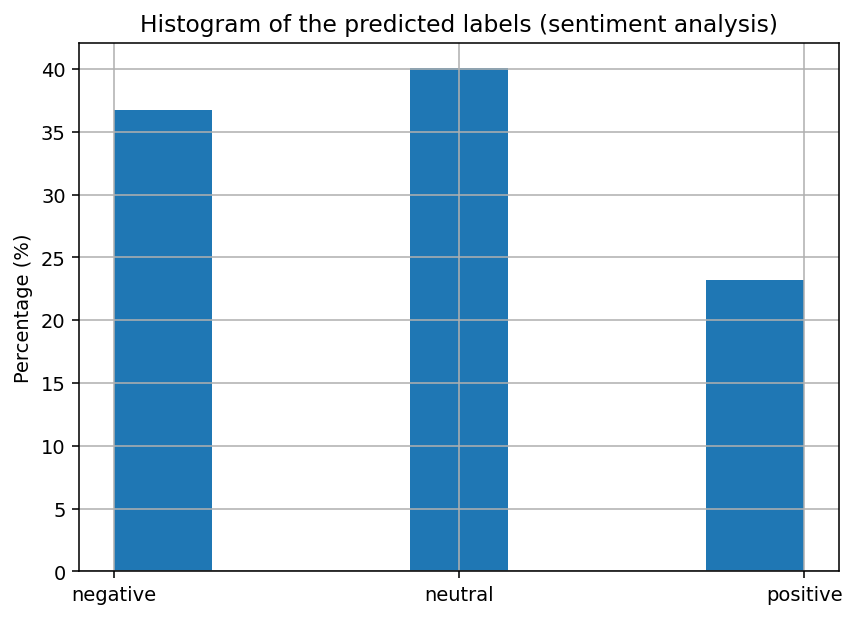

In [18]:
x = np.arange(n_labels)
bins = np.linspace(0, 2, 8)

fig, ax = plt.subplots (figsize=(7, 5), dpi=140)
plt.title ('Histogram of the predicted labels (sentiment analysis)')
#plt.hist (df ['messageSentiment.score'], bins, label=['label'] )
df['messageSentiment.score'].hist(bins=bins, weights=np.ones_like(df[df.columns[0]]) * 100. / len(df))
plt.ylabel('Percentage (%)')
ax.set_xticks (x)
ax.set_xticklabels (list(labels_ids.keys()))
ax.grid(True)
#ax.legend (loc='upper right')
#plt.gca().invert_xaxis()
#plt.gca().invert_yaxis()
plt.show ()

Bar plot of top actors

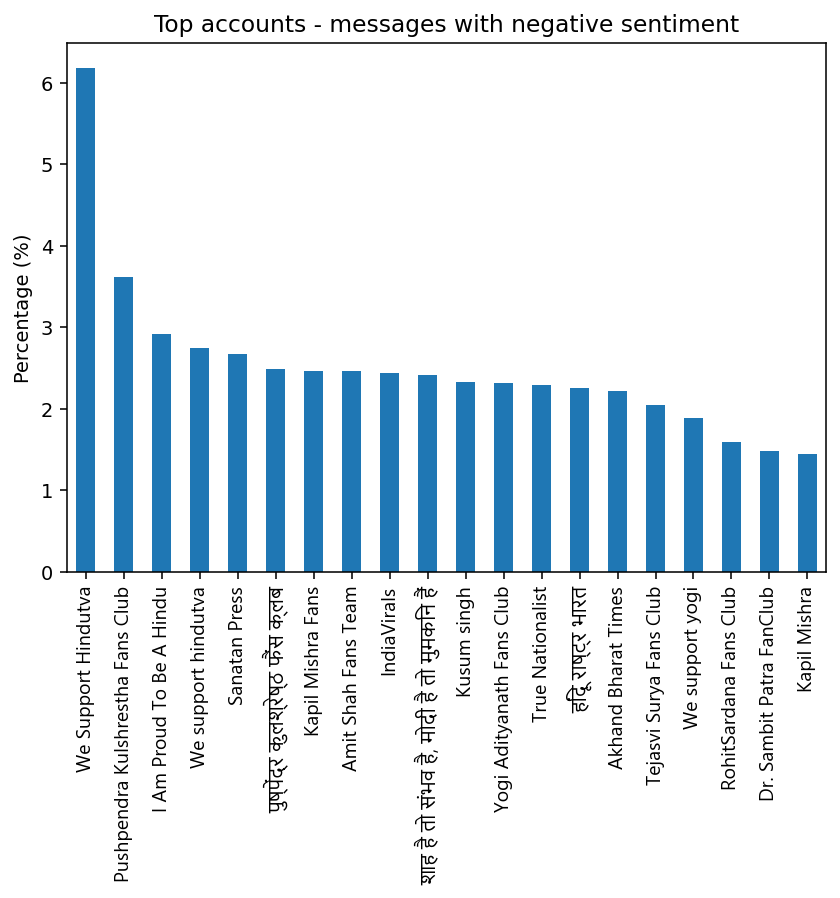

In [19]:
plt.figure(figsize=(7,5),dpi=140)

negative_sentiment = df [df['messageSentiment.score'] == 0]
negative_sentiment_percent = negative_sentiment ['account.name'].value_counts()*100/len(negative_sentiment)
negative_sentiment_percent[:20].plot(kind='bar')

# Customize matplotlib
hindi_font = FontProperties(fname = '/content/drive/MyDrive/CrowdTangle-NLP/Nirmala.ttf')

plt.xticks(fontproperties=hindi_font)
#plt.xticks(rotation = 60)

plt.title('Top accounts - messages with negative sentiment')
plt.ylabel('Percentage (%)')

plt.show()